# AlphaZero version 2

This model was trained from scratch on 1.000.000 training examples from the StageOne dataset on a 6x6 board. The model was trained for 32 epochs.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tf_debug

from keras.callbacks import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
import keras.backend as K
from keras.regularizers import l2
from keras.engine.topology import Layer

from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
import random

from LineFilterLayer import LineFilterLayer

modelPath = 'model/alphaZeroV2.h5'

Using TensorFlow backend.


In [2]:
print(K.image_data_format()) 
# expected output: channels_last

channels_last


In [3]:
def dotsAndBoxesToCategorical(inputData):
    inp = np.copy(inputData)
    inp[inp == 255] = 1 # Line - comes first so that target data only has two categories
    inp[inp == 65] = 2 # Box A
    inp[inp == 150] = 3 # Box B
    inp[inp == 215] = 4 # Dot
    cat = to_categorical(inp)
    newShape = inp.shape + (cat.shape[-1],)
    return cat.reshape(newShape)

In [5]:
rawDataset = np.load('StageOne-6x6-1000000.npz')
x_train = rawDataset['x_train']
y_train = rawDataset['y_train']
x_train_cat = dotsAndBoxesToCategorical(x_train)
y_train_cat = dotsAndBoxesToCategorical(y_train)

np.set_printoptions(precision=2)

print("original data:")
print(x_train[0])
print(y_train[0])
print(x_train.shape)
print(y_train.shape)

print("\nnormalized data:")
print(np.transpose(x_train_cat[0]))
print(np.transpose(y_train_cat[0]))
print(x_train_cat.shape)
print(y_train_cat.shape)

original data:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215 255 215   0 215   0 215   0 215   0 215 255 215   0]
 [  0 255   0   0   0   0   0   0   0 255   0   0   0 255   0]
 [  0 215   0 215   0 215   0 215   0 215 255 215   0 215   0]
 [  0 255   0   0   0   0   0   0   0 255   0   0   0   0   0]
 [  0 215 255 215 255 215   0 215   0 215   0 215 255 215   0]
 [  0   0   0   0   0 255   0 255   0   0   0   0   0 255   0]
 [  0 215   0 215   0 215   0 215   0 215 255 215   0 215   0]
 [  0   0   0   0   0   0   0 255   0   0   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215   0 215   0 215 255 215   0]
 [  0   0   0   0   0 255   0   0   0   0   0 255   0   0   0]
 [  0 215   0 215   0 215 255 215 255 215 255 215   0 215   0]
 [  0   0   0   0   0   0   0   0   0 255   0   0   0 255   0]
 [  0 215   0 215 255 215 255 215   0 215   0 215   0 215   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
[[  0   0   0   0   0   0   0   0   0  

In [3]:
#LineFilterLayer.LineFilterLayer.imgWidth = 13
#LineFilterLayer.LineFilterLayer.imgHeight = 11
#model = load_model('model/alphaZeroV1.h5', custom_objects={'LineFilterLayer':LineFilterLayer.LineFilterLayer})

In [4]:
def imgSizeToBoxes(x):
    return (x-3)/2

def lineFilterMatrixNP(imgWidth,imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=np.bool)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = 1
    return mat

lineFilterMatrixNP(13,11)

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True, False,  True, False,  True, False,  True,
        False,  True, False, False],
       [False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False],
       [False, False,  True,

In [7]:
y_train_lines = y_train[:,lineFilterMatrixNP(y_train.shape[-1], y_train.shape[-2])]
print(y_train_lines.shape)
print(y_train_lines[0])

(1000000, 84)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [10]:
kernelSize = (5,5)
filterCnt = 64
l2reg = 1e-4
resBlockCnt = 4

def build_residual_block(x, index):
        in_x = x
        res_name = "res"+str(index)
        x = Conv2D(filters=filterCnt, kernel_size=kernelSize, padding="same",
                   data_format="channels_last", kernel_regularizer=l2(l2reg), 
                   name=res_name+"_conv1_"+str(filterCnt))(x)
        x = BatchNormalization(name=res_name+"_batchnorm1")(x)
        x = Activation("relu",name=res_name+"_relu1")(x)
        x = Conv2D(filters=filterCnt, kernel_size=kernelSize, padding="same",
                   data_format="channels_last", kernel_regularizer=l2(l2reg), 
                   name=res_name+"_conv2-"+str(filterCnt))(x)
        x = BatchNormalization(name="res"+str(index)+"_batchnorm2")(x)
        x = Add(name=res_name+"_add")([in_x, x])
        x = Activation("relu", name=res_name+"_relu2")(x)
        return x


img_input = Input(shape=(None,None,5,))
x = Conv2D(filterCnt, kernelSize, padding='same', kernel_regularizer=l2(l2reg), name="input_conv")(img_input)
x = Activation("relu", name="input_relu")(x)
x = BatchNormalization()(x)

for i in range(resBlockCnt):
    x = build_residual_block(x, i+1)

res_out = x

x = Conv2D(1, kernelSize, padding='same', kernel_regularizer=l2(l2reg), name="output_conv")(x)
x = LineFilterLayer(y_train.shape[-1], y_train.shape[-2])(x)
x = Activation("softmax", name="output_softmax")(x)
    
model = Model(inputs=img_input, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy')

model.summary()

Tensor("Const:0", shape=(15, 15), dtype=bool)
LineFilterLayer.build()
(None, None, None, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 5 0                                            
__________________________________________________________________________________________________
input_conv (Conv2D)             (None, None, None, 6 8064        input_2[0][0]                    
__________________________________________________________________________________________________
input_relu (Activation)         (None, None, None, 6 0           input_conv[0][0]                 
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, None, None, 6 256         input_relu[0][0]                 
_________________

In [15]:
#sess = K.get_session()
#sess = tf_debug.LocalCLIDebugWrapperSession(sess)
#K.set_session(sess)

# Training
callbacks = []

checkpoint = ModelCheckpoint(filepath=modelPath+".checkpoint", save_weights_only=False)
callbacks.append(checkpoint)

progbar = ProgbarLogger()
callbacks.append(progbar)

tensorboard = TensorBoard(log_dir='model/log2', write_grads=True, write_graph=True, write_images=True, histogram_freq=1)
#callbacks.append(tensorboard)

model.fit(x_train_cat, y_train_lines, epochs=32, batch_size=64, callbacks=callbacks, validation_split=0.001)

model.save(modelPath)

Train on 999000 samples, validate on 1000 samples
Epoch 1/32
Epoch 1/32
999000/999000 [==============================] - 2359s 2ms/step - loss: 458.0807 - val_loss: 495.3993
Epoch 2/32
Epoch 2/32
999000/999000 [==============================] - 2355s 2ms/step - loss: 457.7831 - val_loss: 494.1114
Epoch 3/32
Epoch 3/32
999000/999000 [==============================] - 2378s 2ms/step - loss: 457.5553 - val_loss: 493.5540
Epoch 4/32
Epoch 4/32
999000/999000 [==============================] - 2377s 2ms/step - loss: 457.2870 - val_loss: 494.7955
Epoch 5/32
Epoch 5/32
999000/999000 [==============================] - 2378s 2ms/step - loss: 457.0663 - val_loss: 495.8298
Epoch 6/32
Epoch 6/32
999000/999000 [==============================] - 2378s 2ms/step - loss: 456.8244 - val_loss: 495.7142
Epoch 7/32
Epoch 7/32
999000/999000 [==============================] - 2377s 2ms/step - loss: 456.5152 - val_loss: 496.6829
Epoch 8/32
Epoch 8/32
999000/999000 [==============================] - 2375s 2ms/s

KeyboardInterrupt: 

In [12]:
def linesToDotsAndBoxesImage(lines, imgWidth, imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=lines.dtype)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = lines[idx]
    return mat

example: 108100
[[  0   0   0   0   0   0   0 100   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]
1.0
input (15, 15): 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215 255 215   0 215   0 215   0 215   0 215   0 215   0]
 [  0 255   0   0   0 255   0   0   0 255   0   0   0   0   0]
 [  0 215 255 215   0 215   0 215   0 215   0 215   0 215   0]
 [  0 255   0   0   0   0   0 255   0   0   0   0   0 255   0]
 [  0 215   0 215 255 215 255 215   0 215   0 215 255 215   0]
 [  0 255   0   0   0   0   0   0   0 255   0 255   0   0   0]
 [  0 215 255 215 255 215   0 215   0 215   0 215   0 215   0]
 [  0 255   0   0   0   0   0   0   0 255   0 255   0 255   0]
 [  0 215   0 215   0 215 255 215   0 215   0 21

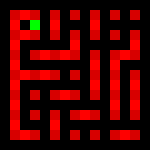

In [19]:
example = random.randrange(x_train.shape[0])
print("example: "+str(example))

input_data = x_train[example:example+1]
input_data_cat = x_train_cat[example:example+1]

prediction_lines = model.predict(input_data_cat)
prediction_lines_print = prediction_lines * 100
print(prediction_lines_print.astype(np.uint8))
print(np.sum(prediction_lines))
prediction = linesToDotsAndBoxesImage(prediction_lines[0], x_train.shape[2], x_train.shape[1])

# print input data
input_data_print = x_train[example,:,:] 
input_data_print = input_data_print.astype(np.uint8)
print("input "+str(input_data_print.shape)+": ")
print(input_data_print)

# generate greyscale image data from input data
target_imgdata = x_train[example,:,:] 
target_imgdata = target_imgdata.astype(np.uint8)

# print prediction
prediction_data_print = prediction * 100 
prediction_data_print = prediction_data_print.astype(np.uint8)
print("prediction: ")
print(prediction_data_print)

# generate greyscale image data from prediction data
prediction_imgdata = prediction * 255
prediction_imgdata = prediction_imgdata.astype(np.uint8)

# merge image data in color channels
tmp = np.zeros((prediction.shape[0], prediction.shape[1]), dtype=np.uint8)
merged_imgdata = np.stack([target_imgdata, prediction_imgdata, tmp], axis=2)

#create image
img = Image.fromarray(merged_imgdata, 'RGB')
img = img.resize(size=(img.size[0]*10, img.size[1]*10))

img